# Import libraries and files

In [36]:
import pickle
import multirecording_spikeanalysis as spike
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA

In [37]:
def pickle_this(thing_to_pickle, file_name):
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    with open(pickle_file, 'rb') as file:
        return pickle.load(file)

# Functions

In [38]:
def extract_relativevar(matrix1_df, matrix2_df, n_comp): # with respect to matrix1 (fit PCA to matrix1)

    '''
    Performs subspace overlap analysis given two data matrices and n number of components to extract.
    '''

    pca = PCA(n_components=n_comp)
    pca.fit(matrix1_df.values)
    matrix1_mean = matrix1_df.values-np.mean(matrix1_df.values, axis=0)
    trans_matrix1 = pca.transform(matrix1_mean)
    inv_matrix1 = pca.inverse_transform(trans_matrix1)
    matrix1_var = np.sum(np.matrix.var(np.asmatrix(inv_matrix1), axis=0))/np.sum(np.matrix.var(np.asmatrix(matrix1_mean), axis=0))
    matrix2_mean = matrix2_df.values-np.mean(matrix2_df.values, axis=0)
    trans_matrix2 = pca.transform(matrix2_mean)
    inv_matrix2 = pca.inverse_transform(trans_matrix2)
    matrix2_var = np.sum(np.matrix.var(np.asmatrix(inv_matrix2), axis=0))/np.sum(np.matrix.var(np.asmatrix(matrix2_mean), axis=0))
    return matrix1_var, matrix2_var

def plot_relativevar(matrix1_df, matrix2_df, n_comp, c1, c2):

    '''
    Perform subspace overlap analysis for 1:n components. The resulting relative variances are displayed in a bar plot.
    '''

    matrix1_vars = [] ; matrix2_vars = []
    # loop through 1:n components to compute the relative variance for each component value
    for i in range(n_comp+1):
        matrix1_var, matrix2_var = extract_relativevar(matrix1_df, matrix2_df, i)
        matrix1_vars.append(matrix1_var) ; matrix2_vars.append(matrix2_var)

    matrix1_contribute = [matrix1_vars[i]-matrix1_vars[i-1] for i in range(len(matrix1_vars)) if i!=0]
    matrix2_contribute = [matrix2_vars[i]-matrix2_vars[i-1] for i in range(len(matrix2_vars)) if i!=0]

    fig, ax = plt.subplots()
    # create data
    x = np.arange(n_comp)
    width = 0.40
    # plot data in grouped manner of bar type 
    plt.bar(x-0.2, matrix1_contribute, width, color=c1)
    plt.bar(x+0.2, matrix2_contribute, width, color=c2)
    ax.set_ylim(0,1)
    ax.set_yticks(np.arange(0,1,0.1))

    plt.show()

In [39]:
def plot_3DPCA(matrix1, matrix2, n_components, mat1color, mat2color):

    '''
    Given two matrices, perform subspace overlap analysis for n components and 3D plot the resulting transformed matrices
    in the colors mat1color and mat2color.
    '''

    # fit to matrix 1
    pca = PCA(n_components=n_components)
    pca.fit(matrix1.values)
    matrix1_mean = matrix1.values-np.mean(matrix1.values, axis=0)
    trans_matrix1 = pca.transform(matrix1_mean)
    matrix2_mean = matrix2.values-np.mean(matrix2.values, axis=0)
    trans_matrix2 = pca.transform(matrix2_mean)

    fig = plt.figure(figsize = (10, 13))
    ax = fig.add_subplot(121, projection="3d")
    ax.scatter(trans_matrix1[:,0], trans_matrix1[:,1], trans_matrix1[:,2], color=mat1color)
    ax.scatter(trans_matrix2[:,0], trans_matrix2[:,1], trans_matrix2[:,2], color=mat2color)

    # fit to matrix 2
    pca = PCA(n_components=n_components)
    pca.fit(matrix2.values)
    matrix1_mean = matrix1.values-np.mean(matrix1.values, axis=0)
    trans_matrix1 = pca.transform(matrix1_mean)
    matrix2_mean = matrix2.values-np.mean(matrix2.values, axis=0)
    trans_matrix2 = pca.transform(matrix2_mean)

    ax = fig.add_subplot(122, projection="3d")
    ax.scatter(trans_matrix1[:,0], trans_matrix1[:,1], trans_matrix1[:,2], color=mat1color)
    ax.scatter(trans_matrix2[:,0], trans_matrix2[:,1], trans_matrix2[:,2], color=mat2color)

    plt.show()

# Phase 2: Freely moving

Each recording is an ephysrecording instance; the documentation is as follows: 

A class for an ephys recording after being spike sorted and manually
curated using phy. Ephys recording must have a phy folder.


    Attributes:
        path: str, relative path to the phy folder
            formatted as: './folder/folder/phy'
        subject: str, subject id who was being recorded
        event_dict: dict, start and stop times for events
            keys: str, name of event types
            values: np.array, d =(n,2), each 2D array is the start and stop time 
            in ms for each event, n = number of events of type key
        sampling_rate: int, sampling rate of the ephys device
            in Hz, standard in the PC lab is 20,000Hz
        timestamps_var: numpy array, all spike timestamps
            of good and mua units (no noise unit-generated spikes)
        unit_array: numpy array, unit ids associated with each
            spike in the timestamps_var
        labels_dict: dict, keys are unit ids (str) and
            values are labels (str)
        unit_timestamps: dict, keys are unit ids (int), and
            values are numpy arrays of timestamps for all spikes
            from "good" units only
        spiketrain: np.array, spiketrain of number of spikes
            in a specified timebin
        unit_spiketrains: dict, spiketrains for each unit
            keys: str, unit ids
            values: np.array, number of spikes per specified timebin
        unit_firing_rates: dict, firing rates per unit
            keys: str, unit ids
            values: np.arrays, firing rate of unit in a specified timebin
                    calculated with a specified smoothing window

    Methods: (all called in __init__)
        get_unit_labels: creates labels_dict
        get_spike_specs: creates timestamps_var and unit_array
        get_unit_timestamps: creates unit_timestamps dictionary


All recordings have been put into an instance of the class type ephysrecordingcollection.
Big picture is that phase2_collection has an attribute called collection which is a dictionary of 
recording names: recording objects. 

In [40]:
phase2_collection = unpickle_this('phase2collection.pkl')

In [41]:
is_first = True
for recording_name, recording in phase2_collection.collection.items():
    if is_first:
        print('Example recording:')
        print(recording_name)
        print("")
        print('Event Types:')
        print(recording.event_dict.keys())
        print("")
        print('Number of units:')
        print(len(recording.unit_timestamps.keys()))
        is_first = False

Example recording:
20230803_101331_1_merged.rec

Event Types:
dict_keys(['acquisition', 'recall', 'cagemate', 'novel', 'exposure 0', 'exposure 1', 'exposure 2', 'exposure 3', 'iti', 'iti_events'])

Number of units:
52


## Spike Analysis Object

Here is another class I made for spike analysis specifically. 

Parameters that you should feel free to play with are smoothin_window and timebin (both in ms).

    Timebin:
        window for each element in all the arrays (spiketrains, firing rates, etc.).
    Smoothing window:
        the rolling average window size to be used when calculating firing rates. 

In [42]:
# PCA analysis parameters
phase2_analysis = spike.SpikeAnalysis_MultiRecording(
    phase2_collection,
    smoothing_window = 500,
    timebin = 50,
    ignore_freq = 0.5)

All set to analyze


## Define familiarity conditions

In [43]:
LT_pc_dict = phase2_analysis.PCA_matrix_generation(equalize=3, pre_window=1, events=['cagemate'])
ST_pc_dict = phase2_analysis.PCA_matrix_generation(equalize=3, pre_window=1, events=['recall'])
acq_pc_dict = phase2_analysis.PCA_matrix_generation(equalize=3, pre_window=1, events=['acquisition'])
novel_pc_dict = phase2_analysis.PCA_matrix_generation(equalize=3, pre_window=1, events=['novel'])
#dict_keys(['acquisition', 'recall', 'cagemate', 'novel', 'exposure 1', 'exposure 2', 'exposure 3'])
LT_matrix_phase2 = LT_pc_dict['raw data']
ST_matrix_phase2 = ST_pc_dict['raw data']
acq_matrix_phase2 = acq_pc_dict['raw data']
novel_matrix_phase2 = novel_pc_dict['raw data']
# all keys: ['acquisition', 'recall', 'cagemate', 'novel', 'exposure 1', 'exposure 2', 'exposure 3']

In [44]:
# use total n=5 components
n_components = 3

## Perform subspace overlap analysis for each combination of conditions

## ST and LT

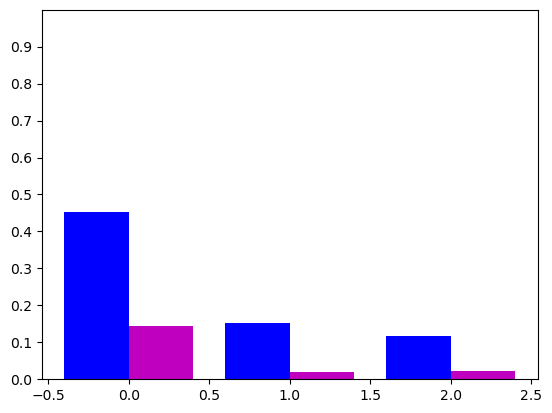

In [45]:
plot_relativevar(LT_matrix_phase2, ST_matrix_phase2, n_components, 'blue', 'm')

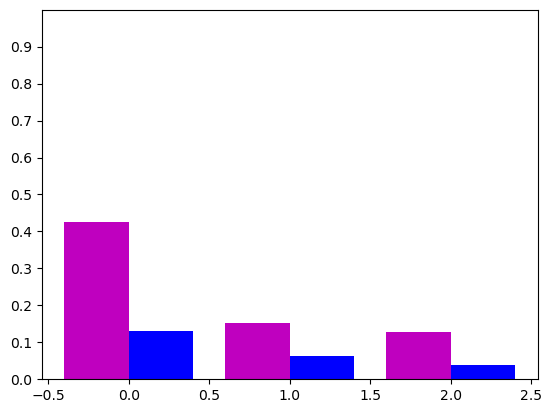

In [46]:
plot_relativevar(ST_matrix_phase2, LT_matrix_phase2, n_components, 'm', 'b')

In [47]:
# calculate alignment index
# 0: PCs do not overlap
# 1: PCs completely overlap
LT_relLT_var, ST_relLT_var = extract_relativevar(LT_matrix_phase2, ST_matrix_phase2, n_components)
ST_relST_var, LT_relST_var = extract_relativevar(ST_matrix_phase2, LT_matrix_phase2, n_components)
print("Alignment index for LT condition:", LT_relST_var/LT_relLT_var)
print("Alignment index for ST condition:", ST_relLT_var/ST_relST_var)

Alignment index for LT condition: 0.32301688068606027
Alignment index for ST condition: 0.2628324641955162


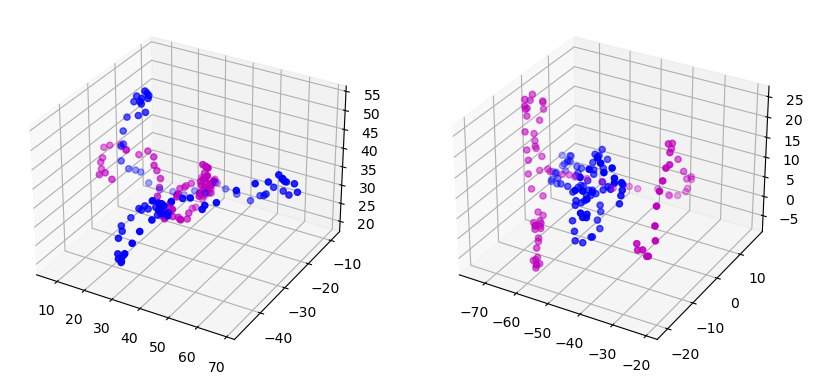

In [48]:
plot_3DPCA(LT_matrix_phase2, ST_matrix_phase2, n_components, 'b', 'm')

## Acquisition and ST

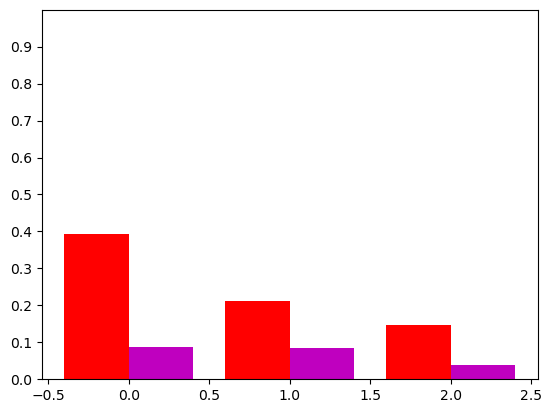

In [49]:
plot_relativevar(acq_matrix_phase2, ST_matrix_phase2, n_components, 'red', 'm')

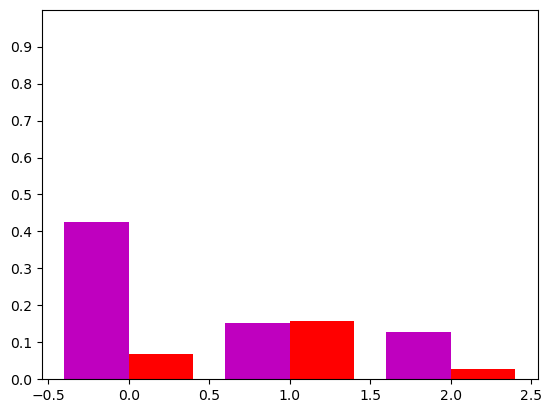

In [50]:
plot_relativevar(ST_matrix_phase2, acq_matrix_phase2, n_components, 'm', 'red')

In [51]:
# calculate alignment index
# 0: PCs do not overlap
# 1: PCs completely overlap
acq_relacq_var, ST_relacq_var = extract_relativevar(acq_matrix_phase2, ST_matrix_phase2, n_components)
ST_relST_var, acq_relST_var = extract_relativevar(ST_matrix_phase2, acq_matrix_phase2, n_components)
print("Alignment index for LT condition:", acq_relST_var/acq_relacq_var)
print("Alignment index for ST condition:", ST_relacq_var/ST_relST_var)

Alignment index for LT condition: 0.33752959534864513
Alignment index for ST condition: 0.2967887492368651


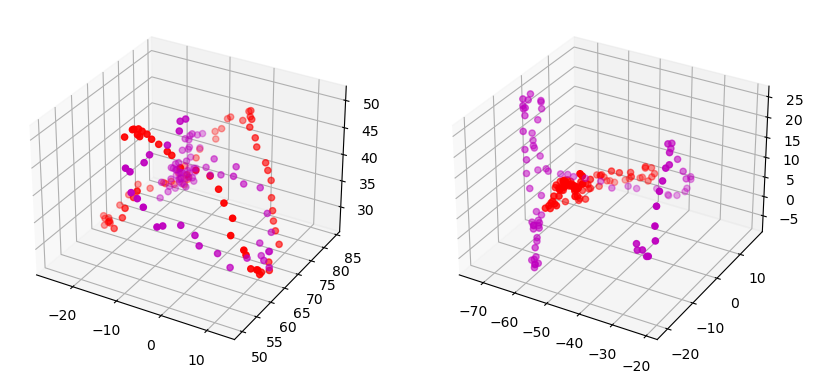

In [52]:
plot_3DPCA(acq_matrix_phase2, ST_matrix_phase2, n_components, 'r', 'm')

## Acquisition and LT

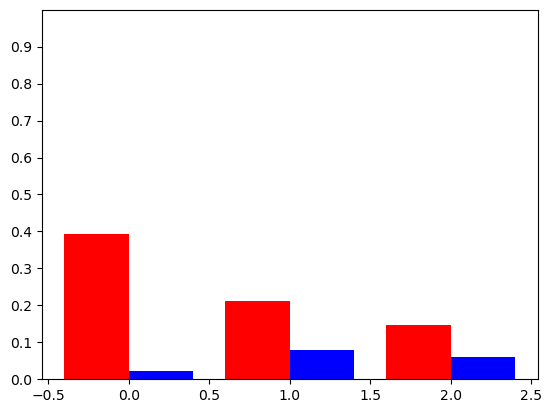

In [53]:
plot_relativevar(acq_matrix_phase2, LT_matrix_phase2, n_components, 'red', 'blue')

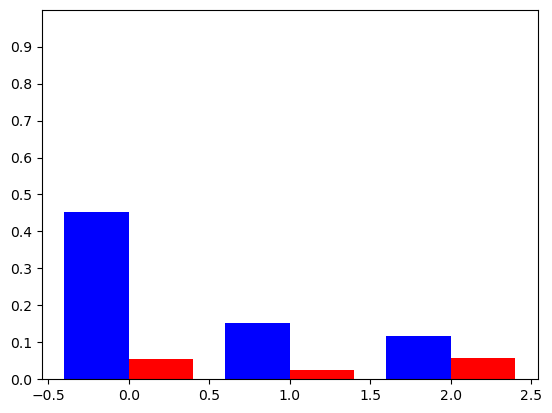

In [54]:
plot_relativevar(LT_matrix_phase2, acq_matrix_phase2, n_components, 'blue', 'red')

In [55]:
# calculate alignment index
# 0: PCs do not overlap
# 1: PCs completely overlap
acq_relacq_var, LT_relacq_var = extract_relativevar(acq_matrix_phase2, LT_matrix_phase2, n_components)
LT_relLT_var, acq_relLT_var = extract_relativevar(LT_matrix_phase2, acq_matrix_phase2, n_components)
print("Alignment index for acquisition condition:", acq_relLT_var/acq_relacq_var)
print("Alignment index for LT condition:", LT_relacq_var/LT_relLT_var)

Alignment index for acquisition condition: 0.18078841520345884
Alignment index for LT condition: 0.22603528236672568


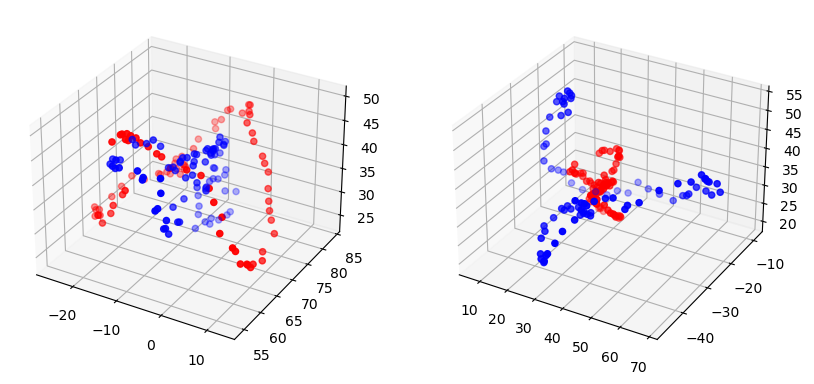

In [56]:
plot_3DPCA(acq_matrix_phase2, LT_matrix_phase2, n_components, 'r', 'b')

## Acquisition and novel

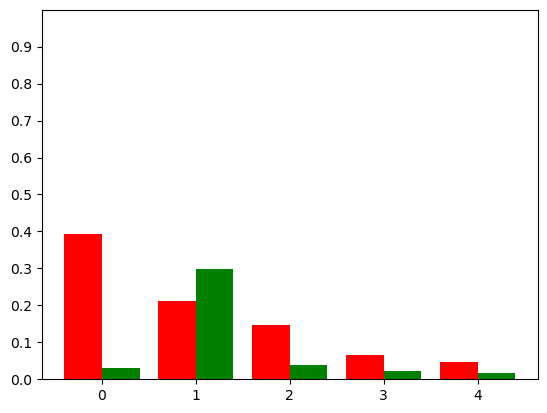

In [57]:
plot_relativevar(acq_matrix_phase2, novel_matrix_phase2, 5, 'red', 'green')

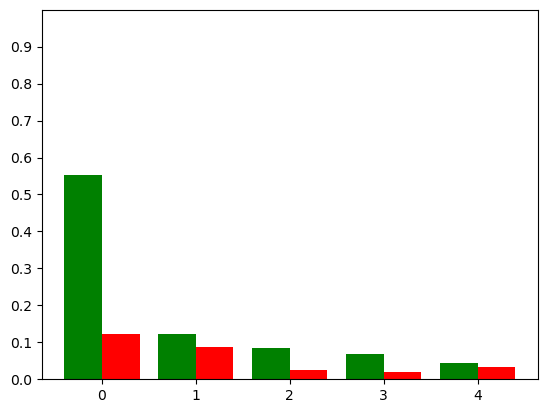

In [58]:
plot_relativevar(novel_matrix_phase2, acq_matrix_phase2, 5, 'g', 'r')

In [59]:
# calculate alignment index
# 0: PCs do not overlap
# 1: PCs completely overlap
acq_relacq_var, novel_relacq_var = extract_relativevar(acq_matrix_phase2, novel_matrix_phase2, 5)
novel_relnovel_var, acq_relnovel_var = extract_relativevar(novel_matrix_phase2, acq_matrix_phase2, 5)
print("Alignment index for acquisition condition:", acq_relnovel_var/acq_relacq_var)
print("Alignment index for novel condition:", novel_relacq_var/novel_relnovel_var)

Alignment index for acquisition condition: 0.3310829607289621
Alignment index for novel condition: 0.46802836198548786


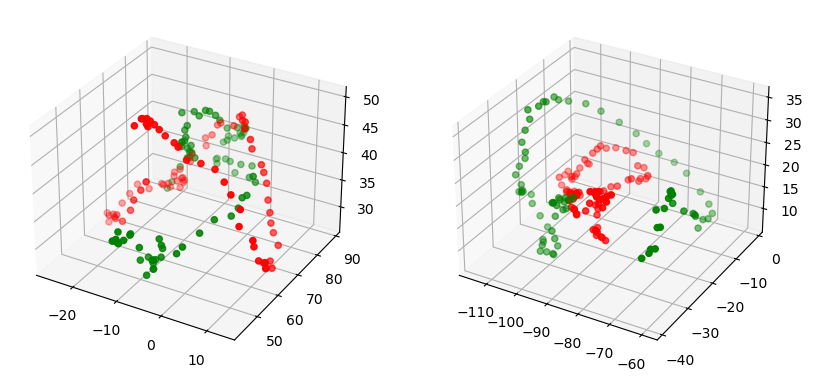

In [60]:
plot_3DPCA(acq_matrix_phase2, novel_matrix_phase2, n_components, 'r', 'g')

## Novel and ST

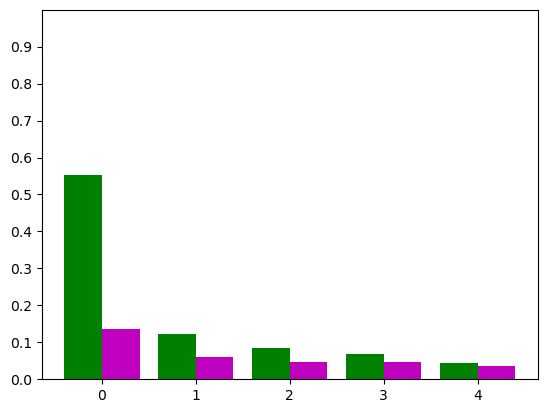

In [61]:
plot_relativevar(novel_matrix_phase2, ST_matrix_phase2, 5, 'g', 'm')

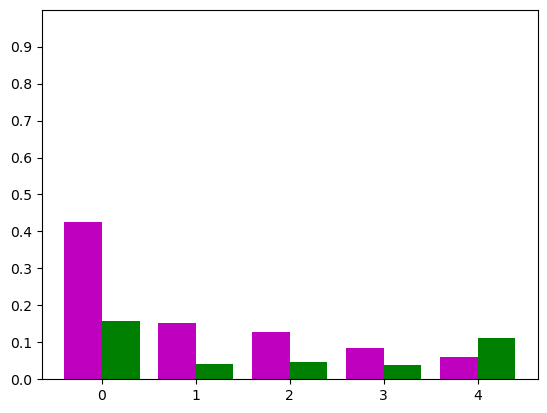

In [62]:
plot_relativevar(ST_matrix_phase2, novel_matrix_phase2, 5, 'm', 'g')

In [63]:
# calculate alignment index
# 0: PCs do not overlap
# 1: PCs completely overlap
novel_relnovel_var, ST_relnovel_var = extract_relativevar(novel_matrix_phase2, ST_matrix_phase2, 5)
ST_relST_var, novel_relST_var = extract_relativevar(ST_matrix_phase2, novel_matrix_phase2, 5)
print("Alignment index for acquisition condition:", novel_relST_var/novel_relnovel_var)
print("Alignment index for novel condition:", ST_relnovel_var/ST_relST_var)

Alignment index for acquisition condition: 0.4548506762996388
Alignment index for novel condition: 0.38275315042453095


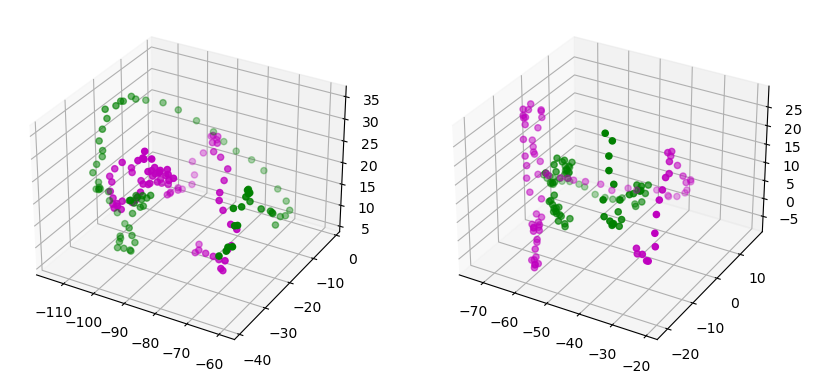

In [64]:
plot_3DPCA(novel_matrix_phase2, ST_matrix_phase2, n_components, 'g', 'm')

## Novel and LT

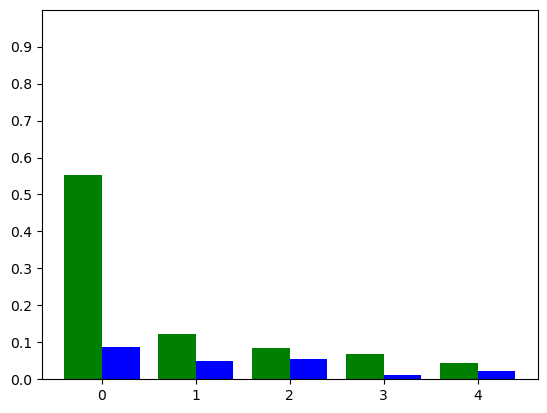

In [65]:
plot_relativevar(novel_matrix_phase2, LT_matrix_phase2, 5, 'g', 'blue')

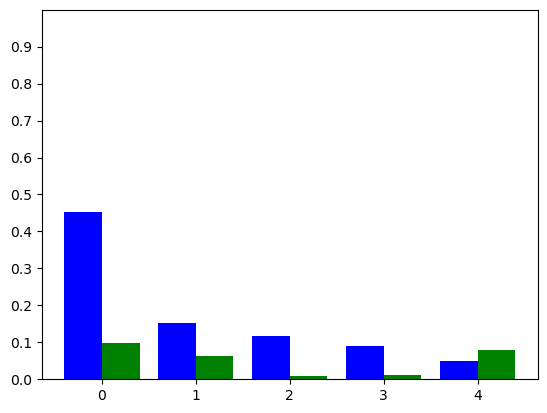

In [66]:
plot_relativevar(LT_matrix_phase2, novel_matrix_phase2, 5, 'blue', 'g')

In [67]:
# calculate alignment index
# 0: PCs do not overlap
# 1: PCs completely overlap
novel_relnovel_var, LT_relnovel_var = extract_relativevar(novel_matrix_phase2, LT_matrix_phase2, 5)
LT_relLT_var, novel_relLT_var = extract_relativevar(LT_matrix_phase2, novel_matrix_phase2, 5)
print("Alignment index for acquisition condition:", novel_relLT_var/novel_relnovel_var)
print("Alignment index for novel condition:", LT_relnovel_var/LT_relLT_var)

Alignment index for acquisition condition: 0.30022149690129024
Alignment index for novel condition: 0.260441449469054


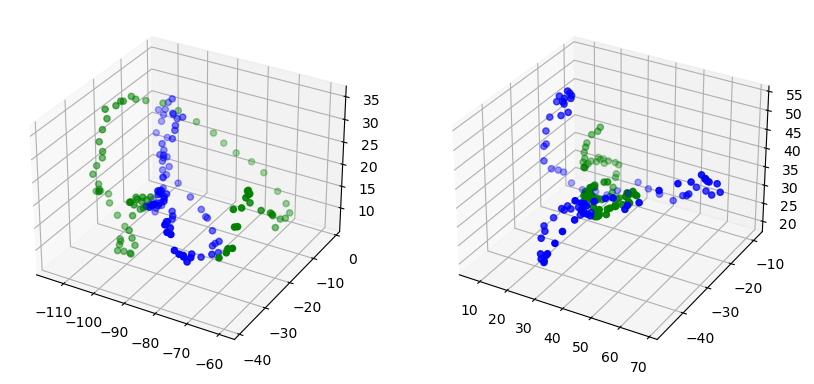

In [68]:
plot_3DPCA(novel_matrix_phase2, LT_matrix_phase2, n_components, 'g', 'b')

## PCA on all data

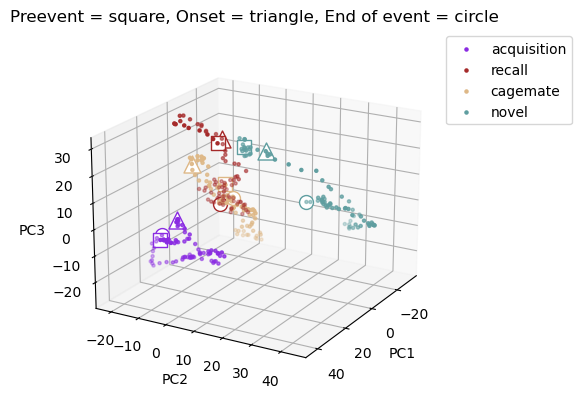

In [69]:
pc_dict = phase2_analysis.PCA_trajectories(equalize = 3, pre_window = 1, post_window = 0, plot = True, save = False,
                                                            events = ['acquisition', 'recall', 'cagemate', 'novel'], d=3)

## Compare alignment index

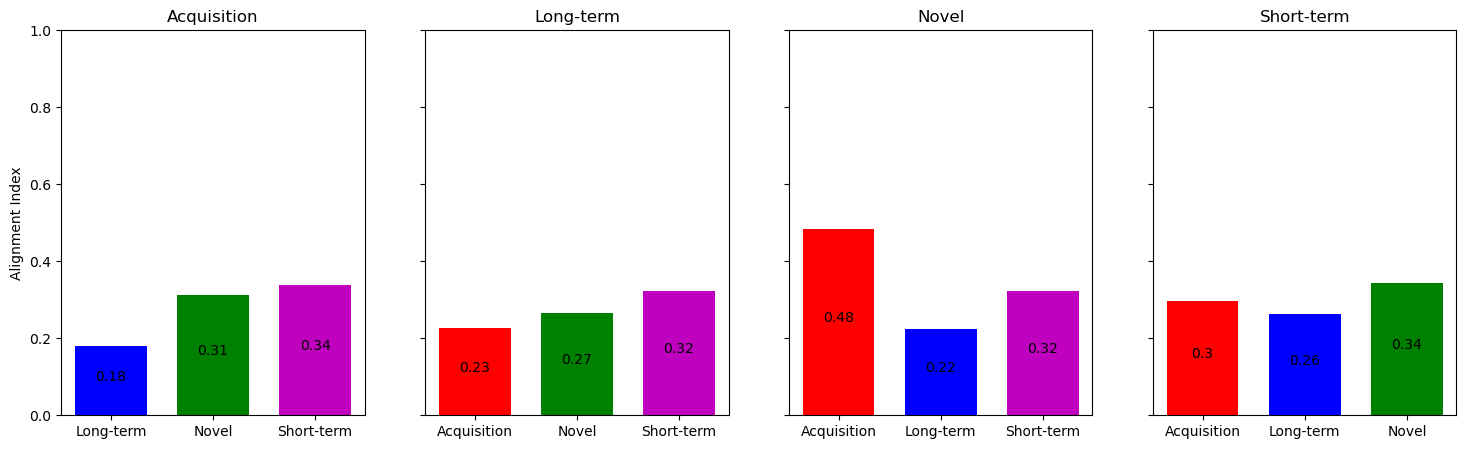

In [70]:
phase2_events = [acq_matrix_phase2, LT_matrix_phase2, novel_matrix_phase2, ST_matrix_phase2]
phase2_events_labels = ['Acquisition', "Long-term", "Novel", "Short-term"]
phase2_events_colors = ['r', "b", "g", "m"]

fig, axes = plt.subplots(1, len(phase2_events), figsize = (18, 5), sharey=True)

plt_idx = 0
# for each condition, perform subspace overlap analysis with other conditions
# then calculate + plot the alignment indexes
for event in phase2_events:
    event_alignidx = []
    for nonevent in phase2_events:
        if np.array_equal(event, nonevent): continue;
        else:
            event_relevent_var, nonevent_relevent_var = extract_relativevar(event, nonevent, n_components)
            nonevent_relnonevent_var, event_relnonevent_var = extract_relativevar(nonevent, event, n_components)
            event_alignidx.append(event_relnonevent_var/event_relevent_var)
    temp_colors = [phase2_events_colors[i] for i in range(len(phase2_events_colors)) if i!=plt_idx]
    axes[plt_idx].bar(np.arange(len(event_alignidx)), event_alignidx, 0.70, color=temp_colors)
    temp_labels = [phase2_events_labels[i] for i in range(len(phase2_events_labels)) if i!=plt_idx]
    axes[plt_idx].set_title(phase2_events_labels[plt_idx])
    axes[plt_idx].set_xticks(np.arange(len(event_alignidx)), temp_labels)
    axes[plt_idx].set_ylim([0, 1])
    axes[0].set_ylabel('Alignment Index')
    for i in range(len(event_alignidx)):
        axes[plt_idx].text(i, event_alignidx[i]/2, round(event_alignidx[i], 2), ha = 'center')
    plt_idx+=1

plt.show()

# Phase 3: Constrained 


In [71]:
phase3_collection = unpickle_this('phase3collection.pkl')

In [72]:
# PCA analysis parameters
phase3_analysis = spike.SpikeAnalysis_MultiRecording(
    phase3_collection,
    smoothing_window = 250, #100
    timebin = 50, #50
    ignore_freq = 0.5)

All set to analyze


## Define familiarity conditions

In [73]:
LT_matrix_phase3, transformed_matrix, key, coefficients, LT_explained_variance_ratios_phase3 = phase3_analysis.PCA_matrix_generation(equalize=5, pre_window=5, events=['cagemate'])
ST_matrix_phase3, transformed_matrix, key, coefficients, ST_explained_variance_ratios_phase3 = phase3_analysis.PCA_matrix_generation(equalize=5, pre_window=5, events=['familiar'])
acq_matrix_phase3, transformed_matrix, key, coefficients, acq_explained_variance_ratios_phase3 = phase3_analysis.PCA_matrix_generation(equalize=5, pre_window=5, events=['acquisition'])
novel_matrix_phase3, transformed_matrix, key, coefficients, novel_explained_variance_ratios_phase3 = phase3_analysis.PCA_matrix_generation(equalize=5, pre_window=5, events=['novel'])
#dict_keys(['acquisition', 'cagemate', 'empty', 'novel', 'familiar'])

In [74]:
n_components = 3

## ST and LT

In [75]:
plot_relativevar(LT_matrix_phase3, ST_matrix_phase3, n_components, 'b', 'm')

AttributeError: 'str' object has no attribute 'values'

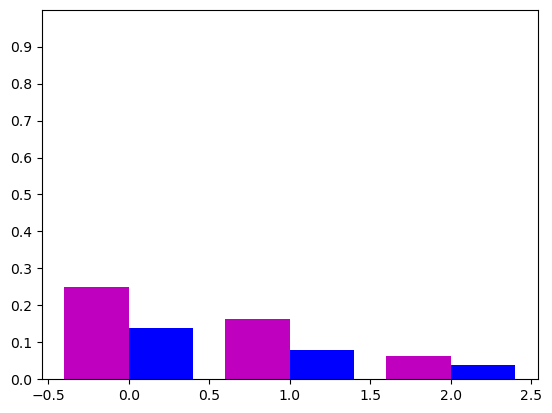

In [ ]:
plot_relativevar(ST_matrix_phase3, LT_matrix_phase3, n_components, 'm', 'b')

In [ ]:
# calculate alignment index
# 0: PCs do not overlap
# 1: PCs completely overlap
LT_relLT_var, ST_relLT_var = extract_relativevar(LT_matrix_phase3, ST_matrix_phase3, n_components)
ST_relST_var, LT_relST_var = extract_relativevar(ST_matrix_phase3, LT_matrix_phase3, n_components)
print("Alignment index for LT condition:", LT_relST_var/LT_relLT_var)
print("Alignment index for ST condition:", ST_relLT_var/ST_relST_var)

Alignment index for LT condition: 0.5350445419327235
Alignment index for ST condition: 0.494805269843059


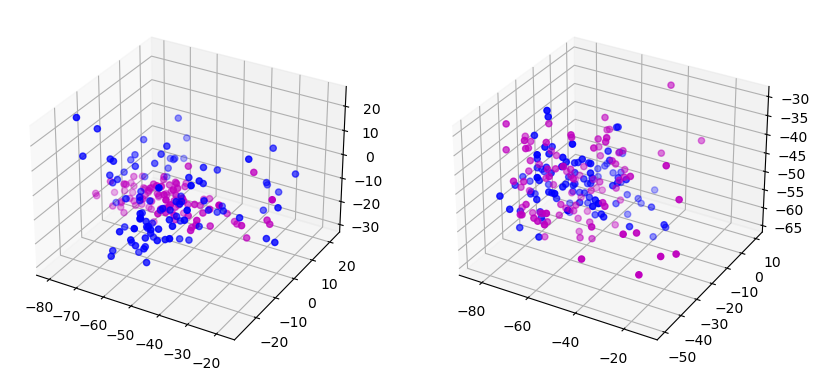

In [ ]:
plot_3DPCA(LT_matrix_phase3, ST_matrix_phase3, n_components, 'b', 'm')

## Acquisition and ST

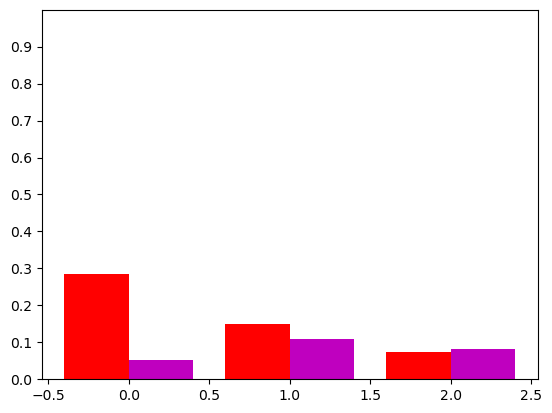

In [ ]:
plot_relativevar(acq_matrix_phase3, ST_matrix_phase3, n_components, 'red', 'm')

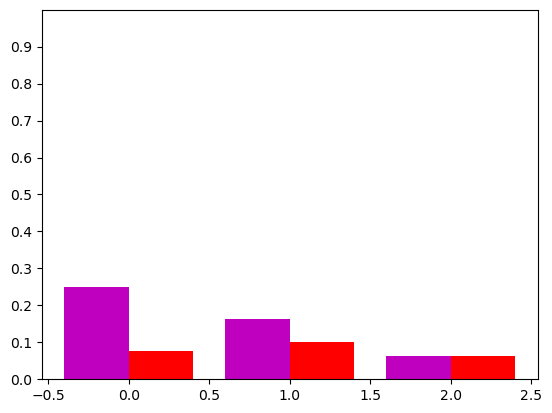

In [ ]:
plot_relativevar(ST_matrix_phase3, acq_matrix_phase3, n_components, 'm', 'r')

In [ ]:
# calculate alignment index
# 0: PCs do not overlap
# 1: PCs completely overlap
acq_relacq_var, ST_relacq_var = extract_relativevar(acq_matrix_phase3, ST_matrix_phase3, n_components)
ST_relST_var, acq_relST_var = extract_relativevar(ST_matrix_phase3, acq_matrix_phase3, n_components)
print("Alignment index for LT condition:", acq_relST_var/acq_relacq_var)
print("Alignment index for ST condition:", ST_relacq_var/ST_relST_var)

Alignment index for LT condition: 0.4671425878176386
Alignment index for ST condition: 0.51415115514479


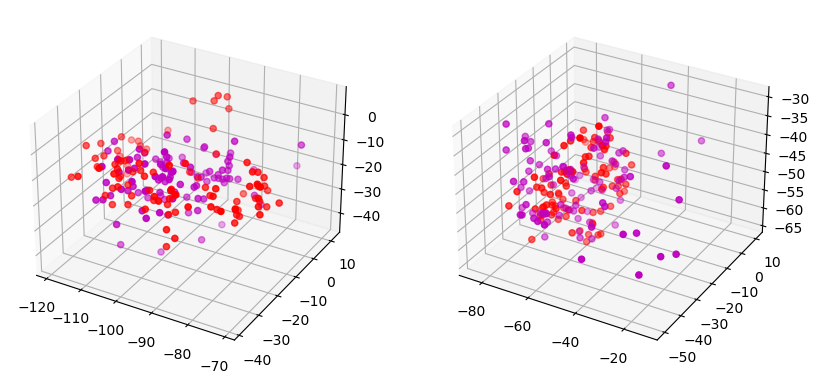

In [ ]:
plot_3DPCA(acq_matrix_phase3, ST_matrix_phase3, n_components, 'r', 'm')

## Acquisition and LT

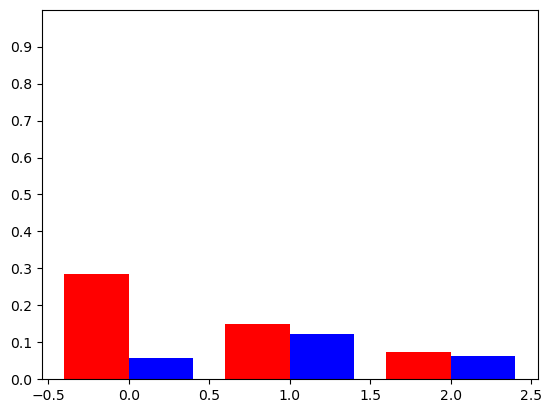

In [ ]:
plot_relativevar(acq_matrix_phase3, LT_matrix_phase3, n_components, 'red', 'blue')

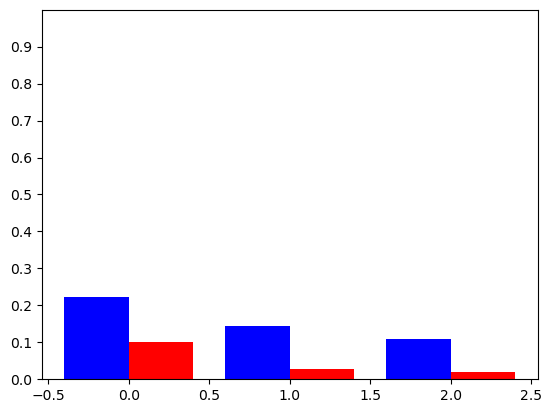

In [ ]:
plot_relativevar(LT_matrix_phase3, acq_matrix_phase3, n_components, 'blue', 'red')

In [ ]:
# calculate alignment index
# 0: PCs do not overlap
# 1: PCs completely overlap
acq_relacq_var, LT_relacq_var = extract_relativevar(acq_matrix_phase3, LT_matrix_phase3, n_components)
LT_relLT_var, acq_relLT_var = extract_relativevar(LT_matrix_phase3, acq_matrix_phase3, n_components)
print("Alignment index for acquisition condition:", acq_relLT_var/acq_relacq_var)
print("Alignment index for LT condition:", LT_relacq_var/LT_relLT_var)

Alignment index for acquisition condition: 0.2948613134678186
Alignment index for LT condition: 0.5089624041430797


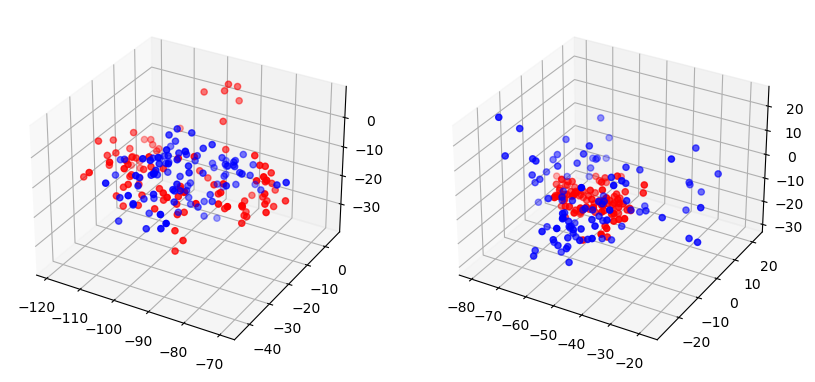

In [ ]:
plot_3DPCA(acq_matrix_phase3, LT_matrix_phase3, n_components, 'r', 'b')

## Acquisition and novel

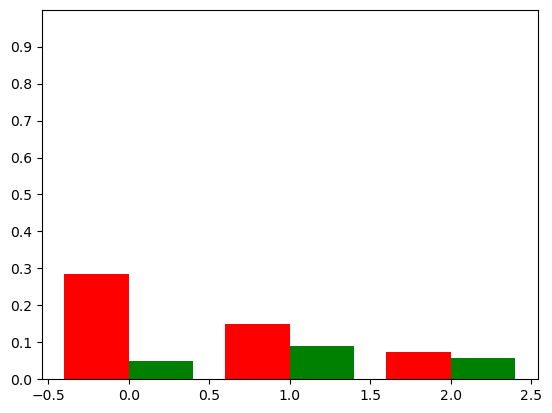

In [ ]:
plot_relativevar(acq_matrix_phase3, novel_matrix_phase3, n_components, 'red', 'g')

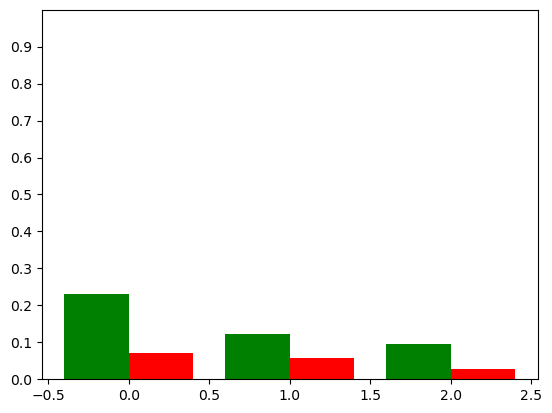

In [ ]:
plot_relativevar(novel_matrix_phase3, acq_matrix_phase3, n_components, 'g', 'red')

In [ ]:
# calculate alignment index
# 0: PCs do not overlap
# 1: PCs completely overlap
acq_relacq_var, novel_relacq_var = extract_relativevar(acq_matrix_phase3, novel_matrix_phase3, n_components)
novel_relnovel_var, acq_relnovel_var = extract_relativevar(novel_matrix_phase3, acq_matrix_phase3, n_components)
print("Alignment index for acquisition condition:", acq_relnovel_var/acq_relacq_var)
print("Alignment index for novel condition:", novel_relacq_var/novel_relnovel_var)

Alignment index for acquisition condition: 0.31175380993238405
Alignment index for novel condition: 0.4412401444966516


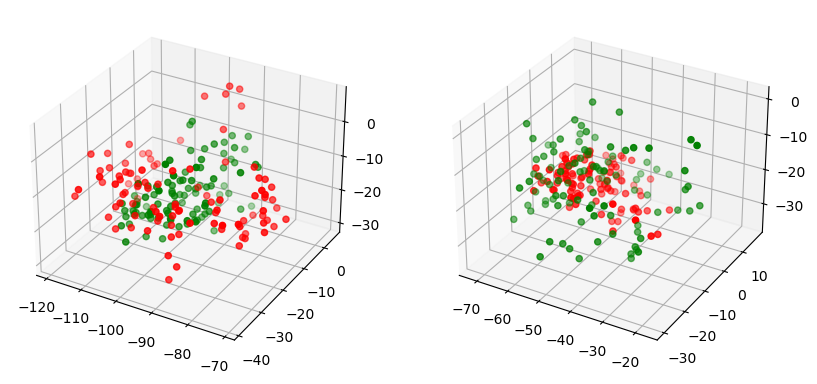

In [ ]:
plot_3DPCA(acq_matrix_phase3, novel_matrix_phase3, n_components, 'r', 'g')

## Novel and ST

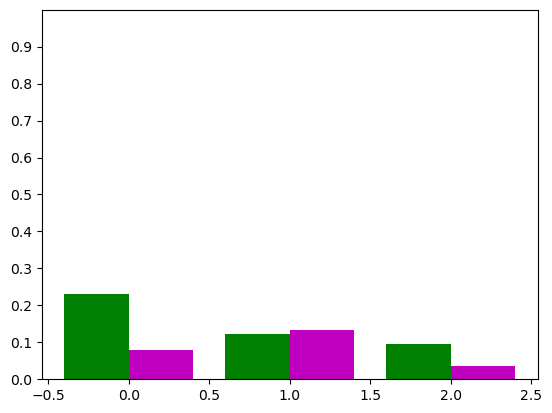

In [ ]:
plot_relativevar(novel_matrix_phase3, ST_matrix_phase3, n_components, 'g', 'm')

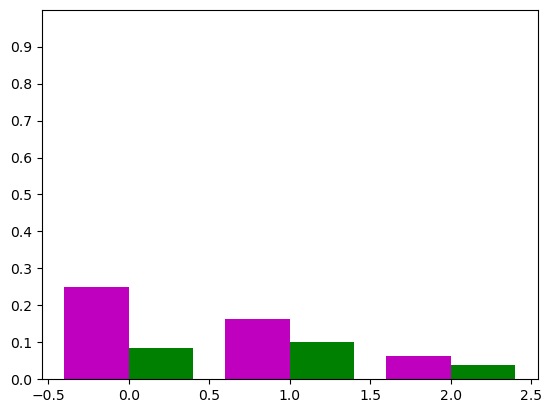

In [ ]:
plot_relativevar(ST_matrix_phase3, novel_matrix_phase3, n_components, 'm', 'g')

In [ ]:
# calculate alignment index
# 0: PCs do not overlap
# 1: PCs completely overlap
novel_relnovel_var, ST_relnovel_var = extract_relativevar(novel_matrix_phase3, ST_matrix_phase3, n_components)
ST_relST_var, novel_relST_var = extract_relativevar(ST_matrix_phase3, novel_matrix_phase3, n_components)
print("Alignment index for acquisition condition:", novel_relST_var/novel_relnovel_var)
print("Alignment index for novel condition:", ST_relnovel_var/ST_relST_var)

Alignment index for acquisition condition: 0.5011062455057091
Alignment index for novel condition: 0.5256185551738098


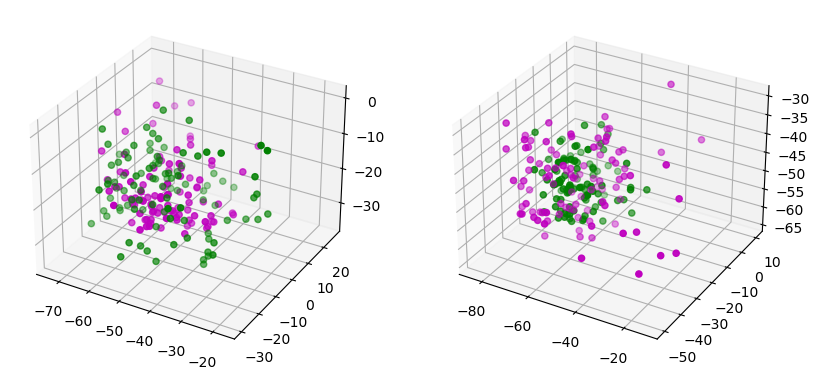

In [ ]:
plot_3DPCA(novel_matrix_phase3, ST_matrix_phase3, n_components, 'g', 'm')

## Novel and LT

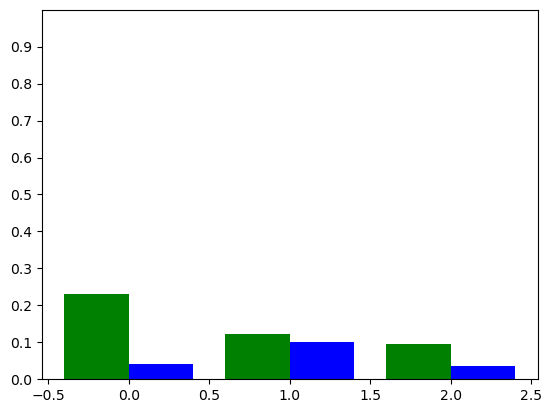

In [ ]:
plot_relativevar(novel_matrix_phase3, LT_matrix_phase3, n_components, 'g', 'blue')

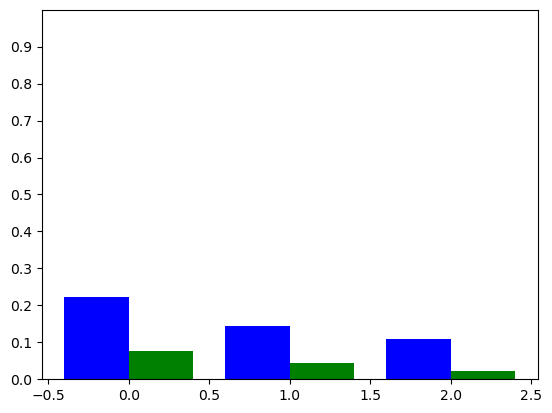

In [ ]:
plot_relativevar(LT_matrix_phase3, novel_matrix_phase3, n_components, 'blue', 'g')

In [ ]:
# calculate alignment index
# 0: PCs do not overlap
# 1: PCs completely overlap
novel_relnovel_var, LT_relnovel_var = extract_relativevar(novel_matrix_phase3, LT_matrix_phase3, n_components)
LT_relLT_var, novel_relLT_var = extract_relativevar(LT_matrix_phase3, novel_matrix_phase3, n_components)
print("Alignment index for acquisition condition:", novel_relLT_var/novel_relnovel_var)
print("Alignment index for novel condition:", LT_relnovel_var/LT_relLT_var)

Alignment index for acquisition condition: 0.3193124716213965
Alignment index for novel condition: 0.37397100477642087


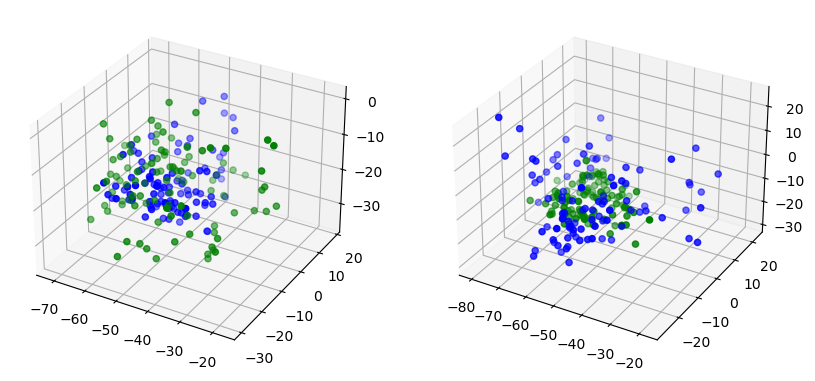

In [ ]:
plot_3DPCA(novel_matrix_phase3, LT_matrix_phase3, n_components, 'g', 'b')

## PCA on all data

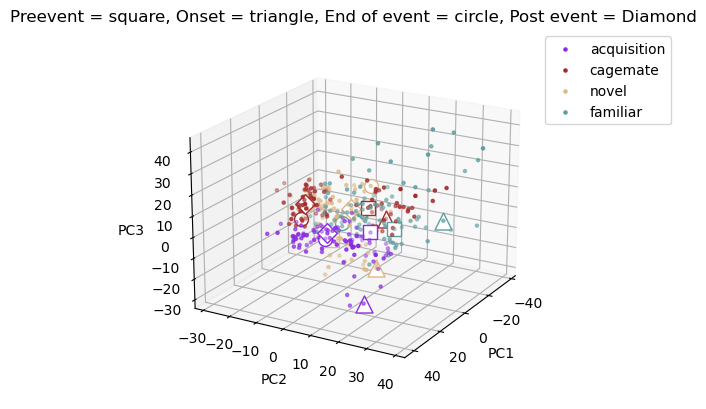

In [ ]:
transformed_matrix, test1, test2 = phase3_analysis.PCA_trajectories(equalize = 5, pre_window = 2, post_window = 2, plot = True, save = False,
                                                            events = ['acquisition', 'cagemate', 'novel', 'familiar'], d=3)

## Compare alignment index

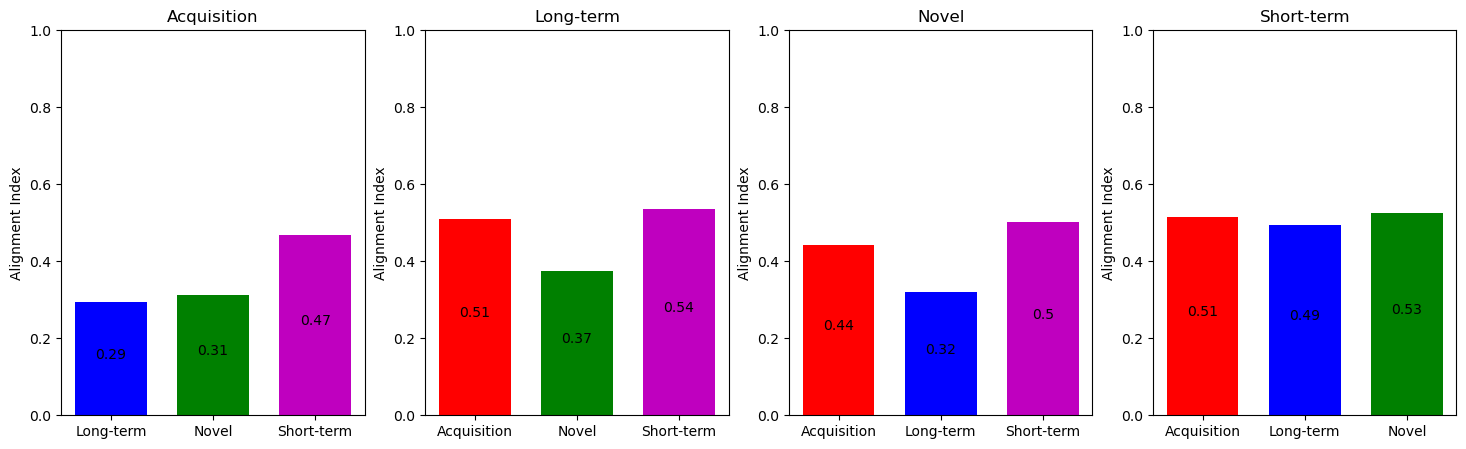

In [ ]:
phase3_events = [acq_matrix_phase3, LT_matrix_phase3, novel_matrix_phase3, ST_matrix_phase3]
phase3_events_labels = ['Acquisition', "Long-term", "Novel", "Short-term"]
phase3_events_colors = ['r', "b", "g", "m"]

fig, axes = plt.subplots(1, len(phase2_events), figsize = (18, 5))

plt_idx = 0
for event in phase3_events:
    event_alignidx = []
    for nonevent in phase3_events:
        if np.array_equal(event, nonevent): continue;
        else:
            event_relevent_var, nonevent_relevent_var = extract_relativevar(event, nonevent, n_components)
            nonevent_relnonevent_var, event_relnonevent_var = extract_relativevar(nonevent, event, n_components)
            event_alignidx.append(event_relnonevent_var/event_relevent_var)
    temp_colors = [phase3_events_colors[i] for i in range(len(phase3_events_colors)) if i!=plt_idx]
    axes[plt_idx].bar(np.arange(len(event_alignidx)), event_alignidx, 0.70, color=temp_colors)
    temp_labels = [phase3_events_labels[i] for i in range(len(phase3_events_labels)) if i!=plt_idx]
    axes[plt_idx].set_title(phase3_events_labels[plt_idx])
    axes[plt_idx].set_xticks(np.arange(len(event_alignidx)), temp_labels)
    axes[plt_idx].set_ylim([0, 1])
    axes[plt_idx].set_ylabel('Alignment Index')
    for i in range(len(event_alignidx)):
        axes[plt_idx].text(i, event_alignidx[i]/2, round(event_alignidx[i], 2), ha = 'center')
    plt_idx+=1

plt.show()